In [0]:
# One step Walk-Forward Validation model
# Treating the categorical variables as continuous

# Import the libraries
import numpy as np
import matplotlib.pyplot as plt
from pandas import read_csv
import math
from keras.models import Sequential
from keras.layers import Input, Dense, Reshape
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

from numpy import argmax
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

In [10]:
# Prepare the data

# Read the ILI activity data, and use only the relavant columns (Remember that the data is already sorted by year, week and then state)
ILI_dataframe = read_csv('final_project.csv', usecols = ['STATENAME', 'ACTIVITY LEVEL', 'WEEK', 'YEAR'])
print(ILI_dataframe)

           STATENAME ACTIVITY LEVEL  YEAR  WEEK
0            Alabama        Level 1  2008    40
1             Alaska        Level 1  2008    40
2            Arizona        Level 1  2008    40
3           Arkansas        Level 6  2008    40
4         California        Level 1  2008    40
...              ...            ...   ...   ...
31865       Virginia       Level 10  2020    12
31866     Washington       Level 10  2020    12
31867  West Virginia       Level 10  2020    12
31868      Wisconsin       Level 10  2020    12
31869        Wyoming        Level 7  2020    12

[31870 rows x 4 columns]


In [11]:
# Get the list of states 
list_of_states_complete = ILI_dataframe['STATENAME'].values # Get entire STATENAME column
states_unique = list(set(list_of_states_complete)) # Unique list of states, but not in alphabetical order
states_unique.sort() # Now in alphabetical order
print(states_unique)

['Alabama', 'Alaska', 'Arizona', 'Arkansas', 'California', 'Colorado', 'Commonwealth of the Northern Mariana Islands', 'Connecticut', 'Delaware', 'District of Columbia', 'Florida', 'Georgia', 'Hawaii', 'Idaho', 'Illinois', 'Indiana', 'Iowa', 'Kansas', 'Kentucky', 'Louisiana', 'Maine', 'Maryland', 'Massachusetts', 'Michigan', 'Minnesota', 'Mississippi', 'Missouri', 'Montana', 'Nebraska', 'Nevada', 'New Hampshire', 'New Jersey', 'New Mexico', 'New York', 'New York City', 'North Carolina', 'North Dakota', 'Ohio', 'Oklahoma', 'Oregon', 'Pennsylvania', 'Puerto Rico', 'Rhode Island', 'South Carolina', 'South Dakota', 'Tennessee', 'Texas', 'Utah', 'Vermont', 'Virgin Islands', 'Virginia', 'Washington', 'West Virginia', 'Wisconsin', 'Wyoming']


In [12]:
# Get the list of activity levels
activity_levels_complete = ILI_dataframe['ACTIVITY LEVEL'].values # Get entire ACTIVITY LEVEL column
activity_levels = list(set(activity_levels_complete)) # Unique list of acitivity levels, not in order
activity_levels.sort() # Activity levels in order
activity_levels.append(activity_levels[2]) # Level 10 was incorrectly sorted, sort it manually
activity_levels.pop(2) # Now correctly sorted
print(activity_levels)

['Level 0', 'Level 1', 'Level 2', 'Level 3', 'Level 4', 'Level 5', 'Level 6', 'Level 7', 'Level 8', 'Level 9', 'Level 10']


In [34]:
# Filter the rows with STATENAME as state_name
state_name = 'Wyoming' # Can change this to loop over the list of states
ILI_Data_state = ILI_dataframe[ILI_dataframe['STATENAME'] == state_name]

# Then filter the rows that do not have year 2020 (We want to predict for the 2018-2019 season)
ILI_Data_state = ILI_Data_state[ILI_Data_state['YEAR'] != 2020]

# Finally, filter out the rows that are in the flu season (Rows with Week 40 to 52)
ILI_Data_state = ILI_Data_state[ILI_Data_state['WEEK'] >= 40]

ILI_Data_state_vals = ILI_Data_state.values

# Manually remove the duplicates in 2011 and 2016
ILI_Data_state_vals = np.delete(ILI_Data_state_vals, 52, 0)
ILI_Data_state_vals = np.delete(ILI_Data_state_vals, 117, 0)
print(ILI_Data_state_vals)

[['Wyoming' 'Level 1' 2008 40]
 ['Wyoming' 'Level 1' 2008 41]
 ['Wyoming' 'Level 1' 2008 42]
 ['Wyoming' 'Level 1' 2008 43]
 ['Wyoming' 'Level 1' 2008 44]
 ['Wyoming' 'Level 1' 2008 45]
 ['Wyoming' 'Level 1' 2008 46]
 ['Wyoming' 'Level 1' 2008 47]
 ['Wyoming' 'Level 1' 2008 48]
 ['Wyoming' 'Level 1' 2008 49]
 ['Wyoming' 'Level 1' 2008 50]
 ['Wyoming' 'Level 1' 2008 51]
 ['Wyoming' 'Level 1' 2008 52]
 ['Wyoming' 'Level 10' 2009 40]
 ['Wyoming' 'Level 10' 2009 41]
 ['Wyoming' 'Level 10' 2009 42]
 ['Wyoming' 'Level 10' 2009 43]
 ['Wyoming' 'Level 8' 2009 44]
 ['Wyoming' 'Level 2' 2009 45]
 ['Wyoming' 'Level 1' 2009 46]
 ['Wyoming' 'Level 1' 2009 47]
 ['Wyoming' 'Level 1' 2009 48]
 ['Wyoming' 'Level 1' 2009 49]
 ['Wyoming' 'Level 1' 2009 50]
 ['Wyoming' 'Level 1' 2009 51]
 ['Wyoming' 'Level 1' 2009 53]
 ['Wyoming' 'Level 1' 2010 40]
 ['Wyoming' 'Level 1' 2010 41]
 ['Wyoming' 'Level 1' 2010 42]
 ['Wyoming' 'Level 1' 2010 43]
 ['Wyoming' 'Level 1' 2010 44]
 ['Wyoming' 'Level 1' 2010 45]
 ['W

In [35]:
ILI_state_activities = list(ILI_Data_state_vals[:, 1])  # List of activity levels in the state
print(ILI_state_activities)

['Level 1', 'Level 1', 'Level 1', 'Level 1', 'Level 1', 'Level 1', 'Level 1', 'Level 1', 'Level 1', 'Level 1', 'Level 1', 'Level 1', 'Level 1', 'Level 10', 'Level 10', 'Level 10', 'Level 10', 'Level 8', 'Level 2', 'Level 1', 'Level 1', 'Level 1', 'Level 1', 'Level 1', 'Level 1', 'Level 1', 'Level 1', 'Level 1', 'Level 1', 'Level 1', 'Level 1', 'Level 1', 'Level 1', 'Level 1', 'Level 1', 'Level 1', 'Level 1', 'Level 1', 'Level 1', 'Level 1', 'Level 1', 'Level 1', 'Level 1', 'Level 1', 'Level 1', 'Level 1', 'Level 1', 'Level 1', 'Level 1', 'Level 1', 'Level 1', 'Level 1', 'Level 1', 'Level 1', 'Level 1', 'Level 1', 'Level 1', 'Level 1', 'Level 1', 'Level 1', 'Level 1', 'Level 5', 'Level 5', 'Level 10', 'Level 10', 'Level 1', 'Level 1', 'Level 1', 'Level 1', 'Level 1', 'Level 1', 'Level 1', 'Level 1', 'Level 1', 'Level 1', 'Level 1', 'Level 1', 'Level 2', 'Level 2', 'Level 1', 'Level 1', 'Level 1', 'Level 1', 'Level 1', 'Level 1', 'Level 1', 'Level 2', 'Level 2', 'Level 3', 'Level 5', 'Le

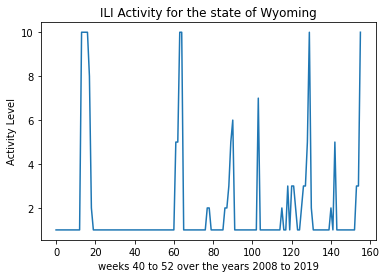

In [36]:
# Plot the state activity as function of weeks 40 to 52 over the years 2008 to 2019

def activity_to_int(activity_lev):
  activity_int = activity_levels.index(activity_lev)
  return activity_int

ILI_state_activities_int = []

for activity_lev in ILI_state_activities:
  ILI_state_activities_int.append(activity_to_int(activity_lev))

plt.plot(ILI_state_activities_int)
plt.xlabel('weeks 40 to 52 over the years 2008 to 2019')
plt.ylabel('Activity Level')
plt.title('ILI Activity for the state of ' + state_name)
plt.show()

In [0]:
# Convert the list of Activities to a numpy array for scaling
ILI_state_activities_int = np.asarray(ILI_state_activities_int, dtype = np.float32)
ILI_state_activities_int = np.reshape(ILI_state_activities_int, (len(ILI_state_activities_int), 1))

# Scale the Activity to a 0-1 range 
scaler = MinMaxScaler(feature_range=(0,1))
ILI_state_activities_scaled = scaler.fit_transform(ILI_state_activities_int)

In [0]:
# Split into train and test sets
# 142 is train size if only last flu season to be predicted
train_size = 142 # int(len(ILI_state_activities_scaled) * 0.67)
test_size = len(ILI_state_activities_scaled) - train_size

train, test = ILI_state_activities_scaled[0:train_size, :], ILI_state_activities_scaled[train_size:len(ILI_state_activities_scaled), :]

In [0]:
# Prepare the data for LSTM, using the sliding window approach. The input X must be of shape (num_samples, num_time_steps, num_features) and the output y must be the same as well.
num_lag_weeks = 1
num_step_weeks = 1

def prepare_LSTM_data(dataset, n_lag, n_step):
  X_list = []
  y_list = []

  for i in range(len(dataset) - (n_lag + n_step) + 1): 
    X_slice = dataset[i:(i+n_lag), :]
    y_slice = dataset[(i+n_lag): (i+n_lag+n_step), 0]

    X_list.append(X_slice)
    y_list.append(y_slice)

  return np.array(X_list), np.array(y_list)

trainX, trainY = prepare_LSTM_data(train, num_lag_weeks, num_step_weeks)
testX, testY = prepare_LSTM_data(test, num_lag_weeks, num_step_weeks)

In [40]:
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(4, input_shape=(1, num_lag_weeks)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=2)

Epoch 1/100
 - 1s - loss: 0.0657
Epoch 2/100
 - 1s - loss: 0.0593
Epoch 3/100
 - 1s - loss: 0.0556
Epoch 4/100
 - 1s - loss: 0.0528
Epoch 5/100
 - 1s - loss: 0.0497
Epoch 6/100
 - 1s - loss: 0.0471
Epoch 7/100
 - 1s - loss: 0.0448
Epoch 8/100
 - 1s - loss: 0.0424
Epoch 9/100
 - 1s - loss: 0.0404
Epoch 10/100
 - 1s - loss: 0.0390
Epoch 11/100
 - 1s - loss: 0.0382
Epoch 12/100
 - 1s - loss: 0.0368
Epoch 13/100
 - 1s - loss: 0.0359
Epoch 14/100
 - 1s - loss: 0.0353
Epoch 15/100
 - 1s - loss: 0.0349
Epoch 16/100
 - 1s - loss: 0.0348
Epoch 17/100
 - 1s - loss: 0.0346
Epoch 18/100
 - 1s - loss: 0.0344
Epoch 19/100
 - 1s - loss: 0.0343
Epoch 20/100
 - 1s - loss: 0.0342
Epoch 21/100
 - 1s - loss: 0.0342
Epoch 22/100
 - 1s - loss: 0.0341
Epoch 23/100
 - 1s - loss: 0.0342
Epoch 24/100
 - 1s - loss: 0.0341
Epoch 25/100
 - 1s - loss: 0.0339
Epoch 26/100
 - 1s - loss: 0.0341
Epoch 27/100
 - 1s - loss: 0.0344
Epoch 28/100
 - 1s - loss: 0.0342
Epoch 29/100
 - 1s - loss: 0.0342
Epoch 30/100
 - 1s - lo

In [41]:
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

# # invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform(trainY)
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform(testY)

# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY, trainPredict))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY, testPredict))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 1.65 RMSE
Test Score: 2.27 RMSE


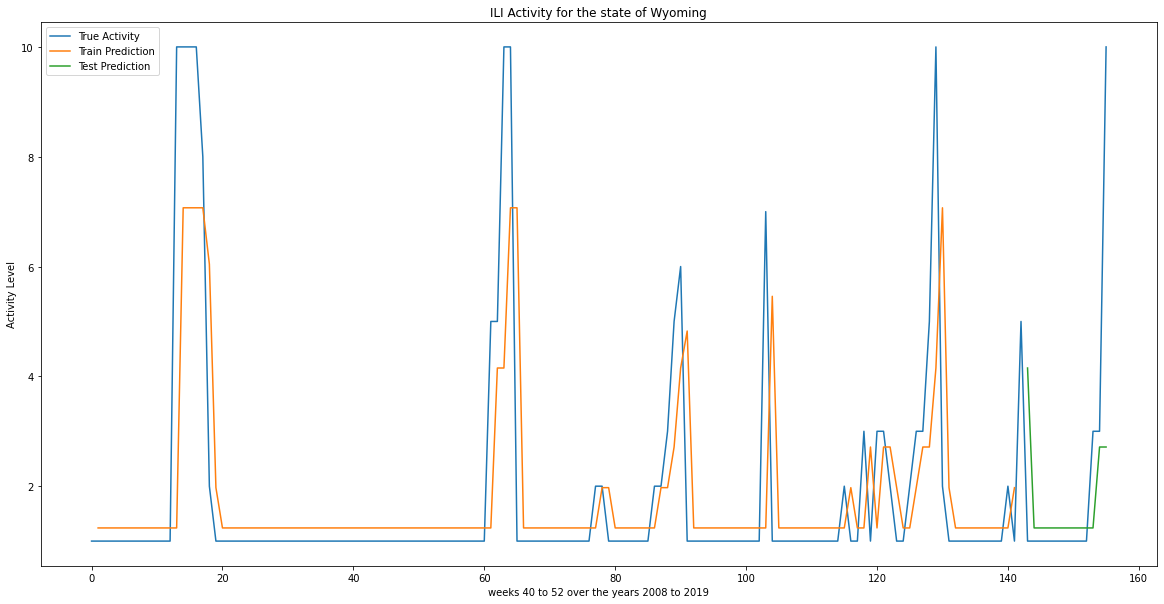

In [42]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(ILI_state_activities_scaled)
trainPredictPlot[:, :] = np.nan
# trainPredictPlot[num_lag_weeks:len(trainPredict)+num_lag_weeks, :] = trainPredict
trainPredictPlot[num_lag_weeks:(len(trainPredict) + 1), :] = trainPredict

# shift test predictions for plotting
testPredictPlot = np.empty_like(ILI_state_activities_scaled)
testPredictPlot[:, :] = np.nan
# testPredictPlot[-(test_size-1):, :] = testPredict
start_test_point = len(trainPredict) + 2
testPredictPlot[start_test_point:, :] = testPredict

# plot baseline and predictions
plt.figure(figsize = (20,10))
plt.plot(scaler.inverse_transform(ILI_state_activities_scaled))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.xlabel('weeks 40 to 52 over the years 2008 to 2019')
plt.ylabel('Activity Level')
plt.title('ILI Activity for the state of ' + state_name)
plt.legend(['True Activity', 'Train Prediction', 'Test Prediction'])
plt.show()

In [0]:
# Check what the test predictions look like
testPredictRound = np.around(testPredict)

[[3.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [2.]
 [4.]
 [1.]
 [1.]
 [2.]
 [3.]
 [7.]]
[[2.812043 ]
 [1.3851646]
 [1.3851646]
 [1.3851646]
 [1.3851646]
 [1.3851646]
 [2.093455 ]
 [3.5306866]
 [1.3851646]
 [1.3851646]
 [2.093455 ]
 [2.812043 ]
 [7.4324684]]


In [0]:
result_list = []
for i in range(len(testPredictRound)):
  result_list.append(activity_levels[int(testPredictRound[i, 0])])

print(result_list)

['Level 3', 'Level 1', 'Level 1', 'Level 1', 'Level 1', 'Level 1', 'Level 2', 'Level 4', 'Level 1', 'Level 1', 'Level 2', 'Level 3', 'Level 7']
